In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score


In [2]:
# Load Dataset
df_full = pd.read_csv('../data/regression_lufu_2021-08-03.csv')

In [3]:
# Select variables
selected = [
    'id', 'gender', 'apgar_5min',
    'respiration_inv_days',
    'respiration_non_inv_days',
    'early_onset_infection', 'steroids', 'bpd_severity',
    'gest_age', 'birth_weight_g','body_size_cm',
    'volume', 'volume_ratio', 
]

df_regression=df_full[selected]

# Add variable of respiratory support (invasive + non-invasive)
resp_support_days = df_regression['respiration_inv_days'].to_numpy()+df_regression['respiration_non_inv_days'].to_numpy()
df_regression.insert(5, "resp_support_days", resp_support_days, True)

# Change gender to numerical 
gender_dict = {'f':0, 'm':1}
df_regression.replace({"gender": gender_dict}, inplace=True)

# Create volume variable but normalized by the birth weight
volume_per_kg= 1000*df_regression['volume'].to_numpy()/df_regression['birth_weight_g'].to_numpy()
df_regression.insert(13, "volume_per_kg", volume_per_kg, True)

# Create binary prediction variables
binary_no_vs_all = df_regression['bpd_severity'].apply(lambda x: 0 if x < 1 else 1)
df_regression.insert(15, "bpd_no_vs_all", binary_no_vs_all, True)

binary_mild_vs_severe = df_regression['bpd_severity'].apply(lambda x: 0 if x < 2 else 1)
df_regression.insert(16, "bpd_mild_vs_severe", binary_mild_vs_severe, True)


/Users/castelblanco/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [4]:
def nested_cross_validation(X, y, penalty_lasso, random_states, n_splits_outer=5, n_splits_inner=5, n_grid=10):
    
    grid_best_scores = []
    grid_best_Cs = []
    logistic_model_auc = []
    logistic_model_f1 = []
    log_model_weights = []
    tprs = []
    fprs =[]
    thresholds = []
    outer_fold = []
    repetition_n = []
        
    for i in range(len(random_states)):
        random_state_i = random_states[i]
        p_grid = {
            "C": np.logspace(-4, 1, n_grid, endpoint=True),
                 }
        
        log_model_grid = LogisticRegression(
            random_state=random_state_i, 
            penalty=penalty_lasso,
            solver='liblinear')

        # OUTER FOLD
        outter_cv = StratifiedKFold(n_splits=n_splits_outer, shuffle=True, random_state=random_state_i).split(X, y)
        for j, (train, test) in enumerate(outter_cv):
            x_train = X.loc[train]
            y_train = y.loc[train]
            x_test = X.loc[test]
            y_test = y.loc[test]

            scaler = StandardScaler()
            scaler.fit(x_train)
            scaled_x_train = scaler.transform(x_train)
            scaled_x_test = scaler.transform(x_test)

            # Inner Fold => Find the best parameter
            inner_cv = StratifiedKFold(n_splits=n_splits_inner, shuffle=True, random_state=random_state_i)
            grid = GridSearchCV(estimator=log_model_grid, param_grid=p_grid, cv=inner_cv, scoring='f1')
            grid.fit(scaled_x_train,y_train)
            grid_best_scores.append(grid.best_score_)
            grid_best_Cs.append(grid.best_estimator_.C)

            # Use the best parameter of the inner fold on the test
            model_logistic = LogisticRegression(
                random_state=random_state_i, 
                C=grid.best_estimator_.C, 
                penalty=penalty_lasso,
                solver='liblinear').fit(scaled_x_train, y_train)

            # Perform Predictions
            predictions = model_logistic.predict(scaled_x_test)
            predictions_decision = model_logistic.decision_function(scaled_x_test)
            test_fpr, test_tpr, test_thresholds = roc_curve(y_test, predictions_decision)

            y_predict_proba = model_logistic.predict_proba(scaled_x_test)[:,1]
            roc_auc = roc_auc_score(y_test, y_predict_proba)
            f1_temp = f1_score(y_test, predictions, average='weighted')

            logistic_model_auc.append(roc_auc)
            logistic_model_f1.append(f1_temp)
            log_model_weights.append(model_logistic.coef_[0])
            tprs.append(test_tpr)
            fprs.append(test_fpr)
            thresholds.append(test_thresholds)
            outer_fold.append(j)
            repetition_n.append(i)

    df_results = pd.DataFrame.from_dict({
    'repetition_n':repetition_n,
    'outer_fold':outer_fold,
    'grid_best_inner_f1': grid_best_scores,
    'grid_best_Cs': grid_best_Cs,
    'logistic_model_auc': logistic_model_auc,
    'logistic_model_f1': logistic_model_f1,
    'log_model_weights':log_model_weights,
    'tprs': tprs,
    'fprs':fprs,
    'thresholds':thresholds,
    })

    return df_results

In [5]:
def get_avg_auc_and_f1(df_in, print_out=True):   
    avg_by_repetition = df_in[['repetition_n','logistic_model_auc','logistic_model_f1']].groupby('repetition_n').mean()
    std_by_repetition = df_in[['repetition_n','logistic_model_auc','logistic_model_f1']].groupby('repetition_n').std()
    
    avg_auc = np.mean(avg_by_repetition['logistic_model_auc'].to_numpy())
    std_auc = np.mean(std_by_repetition['logistic_model_auc'].to_numpy())
    avg_f1 = np.mean(avg_by_repetition['logistic_model_f1'].to_numpy())
    std_f1 = np.mean(std_by_repetition['logistic_model_f1'].to_numpy())
    
    if print_out:
        print('auc',avg_auc*100, '+/-', std_auc*100)
        print('f1',avg_f1*100, '+/-', std_f1*100)
    return avg_auc, std_auc, avg_f1, std_f1
    

# Nested Cross Validation

In [14]:
random_array = [1,50,234,3,5,789,45,658,9,429]  

### L1 and L2 Only Volume Features

In [7]:
explanatory = [
    'volume_per_kg', 
    'volume_ratio', 
]

y_in=df_regression['bpd_no_vs_all']
X_in=df_regression[explanatory]

l1_only_volume = nested_cross_validation(X_in, y_in, penalty_lasso='l1', random_states=random_array)
print('L1')
avg_auc, std_auc, avg_f1, std_f1 = get_avg_auc_and_f1(l1_only_volume)


l2_only_volume = nested_cross_validation(X_in, y_in, penalty_lasso='l2', random_states=random_array)
print('L2')
avg_auc, std_auc, avg_f1, std_f1 = get_avg_auc_and_f1(l2_only_volume)


L1
auc 84.31292517006803 +/- 8.665185530163635
f1 81.54071504476825 +/- 8.290447870219959
L2
auc 84.11224489795919 +/- 8.849340298828798
f1 79.357516445703 +/- 7.963923422715427


### L1 and L2  Volume + Subject Features

In [8]:
explanatory = [
    'gender', 'gest_age', 'birth_weight_g','body_size_cm',
    'volume_per_kg', 'volume_ratio', 
]

y_in=df_regression['bpd_no_vs_all']
X_in=df_regression[explanatory]

l1_volume_subject = nested_cross_validation(X_in, y_in, penalty_lasso='l1',random_states=random_array)
print('L1')
avg_auc, std_auc, avg_f1, std_f1 = get_avg_auc_and_f1(l1_volume_subject)

l2_volume_subject = nested_cross_validation(X_in, y_in, penalty_lasso='l2',random_states=random_array)
print('L2')
avg_auc, std_auc, avg_f1, std_f1 = get_avg_auc_and_f1(l2_volume_subject)


L1
auc 89.39795918367346 +/- 7.949759534458127
f1 83.7134566366083 +/- 7.350964417185465
L2
auc 89.11564625850342 +/- 8.475048161278892
f1 83.95362851716772 +/- 7.25050097263699


### L1 and L2  Volume + Subject + Clinical Features

In [9]:
explanatory = [
    'gender', 'gest_age', 'birth_weight_g','body_size_cm',
    'apgar_5min','early_onset_infection', 'steroids',
    'volume_per_kg', 'volume_ratio', 
]

y_in=df_regression['bpd_no_vs_all']
X_in=df_regression[explanatory]

l1_volume_subject_clinical = nested_cross_validation(X_in, y_in, penalty_lasso='l1',random_states=random_array)
print('L1')
avg_auc, std_auc, avg_f1, std_f1 = get_avg_auc_and_f1(l1_volume_subject_clinical)


l2_volume_subject_clinical = nested_cross_validation(X_in, y_in, penalty_lasso='l2',random_states=random_array)
print('L2')
avg_auc, std_auc, avg_f1, std_f1 = get_avg_auc_and_f1(l2_volume_subject_clinical)


L1
auc 89.51360544217687 +/- 8.19623917481441
f1 83.31489550716732 +/- 8.196007039433564
L2
auc 88.57482993197279 +/- 9.21337107416682
f1 84.02334628047822 +/- 7.076028426943952


## Plot comparing Models with Features

In [10]:

aucs = np.concatenate([
    l1_only_volume['logistic_model_auc'],
    l2_only_volume['logistic_model_auc'],
    l1_volume_subject['logistic_model_auc'],
    l2_volume_subject['logistic_model_auc'],
    l1_volume_subject_clinical['logistic_model_auc'],
    l2_volume_subject_clinical['logistic_model_auc'],]
)

f1s = np.concatenate([
    l1_only_volume['logistic_model_f1'],
    l2_only_volume['logistic_model_f1'],
    l1_volume_subject['logistic_model_f1'],
    l2_volume_subject['logistic_model_f1'],
    l1_volume_subject_clinical['logistic_model_f1'],
    l2_volume_subject_clinical['logistic_model_f1'],]
)

selected_features = np.concatenate([
    np.repeat('V', 2*len(l1_only_volume['logistic_model_auc'])),
    np.repeat('V + S', 2*len(l1_volume_subject['logistic_model_auc'])),
    np.repeat('V + S + C', 2*len(l1_volume_subject_clinical['logistic_model_auc'])),
]) 

penalty = np.concatenate([
    np.repeat('l1', len(l1_only_volume['logistic_model_auc'])),
    np.repeat('l2', len(l1_only_volume['logistic_model_auc'])),
    np.repeat('l1', len(l1_only_volume['logistic_model_auc'])),
    np.repeat('l2', len(l1_only_volume['logistic_model_auc'])),
    np.repeat('l1', len(l1_only_volume['logistic_model_auc'])),
    np.repeat('l2', len(l1_only_volume['logistic_model_auc'])),
]) 


df_plot_results = pd.DataFrame.from_dict({
    'auc':aucs,
    'f1':f1s,
    'Features': selected_features,
    'Penalty': penalty,
})

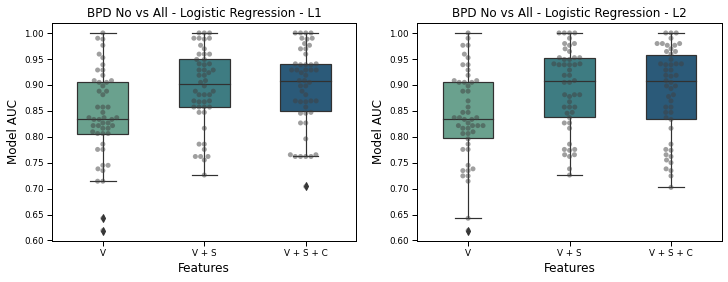

In [11]:
sns.set_context("paper")

font_s = 12
f = plt.figure(figsize=(12, 4))
gs = f.add_gridspec(1, 2)

df_plot_results_l1 = df_plot_results.loc[df_plot_results['Penalty']=='l1']
df_plot_results_l2 = df_plot_results.loc[df_plot_results['Penalty']=='l2']




ax = f.add_subplot(gs[0])
sns.boxplot(x='Features', y='auc',
            data=df_plot_results_l1, 
            palette = 'crest',
            width = 0.5,
           )
sns.swarmplot(x='Features', y='auc',
              data=df_plot_results_l1,
              color=".25",
              alpha=0.5
           )
ax.set_title('BPD No vs All - Logistic Regression - L1', fontsize = font_s)
ax.set_ylabel('Model AUC', fontsize = font_s)
ax.set_xlabel('Features', fontsize = font_s)


ax = f.add_subplot(gs[1])
sns.boxplot(x='Features', y='auc',
            data=df_plot_results_l2, 
            palette = 'crest',
            width = 0.5,
           )
sns.swarmplot(x='Features', y='auc',
              data=df_plot_results_l2,
              color=".25",
              alpha=0.5
           )
ax.set_title('BPD No vs All - Logistic Regression - L2', fontsize = font_s)
ax.set_ylabel('Model AUC', fontsize = font_s)
ax.set_xlabel('Features', fontsize = font_s)

ax.set_axisbelow(True)

plt.show()

V = ['volume_per_kg', 'volume_ratio']


S = ['gender', 'gest_age', 'birth_weight_g','body_size_cm']


C = ['apgar_5min','early_onset_infection', 'steroids']

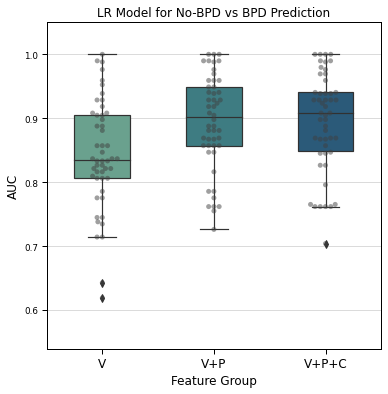

In [12]:
sns.set_context("paper")

font_s = 12
f = plt.figure(figsize=(6, 6))
gs = f.add_gridspec(1, 1)

df_plot_results_l1 = df_plot_results.loc[df_plot_results['Penalty']=='l1']
df_plot_results_l2 = df_plot_results.loc[df_plot_results['Penalty']=='l2']




ax = f.add_subplot(gs[0])
sns.boxplot(x='Features', y='auc',
            data=df_plot_results_l1, 
            palette = 'crest',
            width = 0.5,
           )
sns.swarmplot(x='Features', y='auc',
              data=df_plot_results_l1,
              color=".25",
              alpha=0.5
           )
ax.set_title('LR Model for No-BPD vs BPD Prediction', fontsize = font_s)
ax.set_ylabel('AUC', fontsize = font_s)
ax.set_xlabel('Feature Group', fontsize = font_s)
ax.set_ylim([0.54, 1.05]) 

ax.set_xticklabels(['V','V+P','V+P+C'], fontsize = 12)

ax.set_axisbelow(True)
ax.yaxis.grid(color='lightgray')

plt.savefig('LogREG_AUC.pdf')
plt.show()

# Plot the ROC 

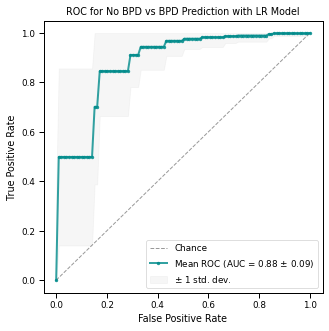

In [13]:
# Plot the ROC 
df_results = l2_volume_subject_clinical

log_model_weights=df_results['log_model_weights']
tprs=df_results['tprs']
fprs=df_results['fprs']
aucs = df_results['logistic_model_auc']

tprs_interp =[]

#Interpolate tprs to find average for ROC 
mean_fpr = np.linspace(0, 1, 100)
for i in range(len(tprs)):
    tpr_temp = tprs[i]
    fpr_temp = fprs[i]
    interp_tpr_temp = np.interp(mean_fpr, fpr_temp, tpr_temp)
    tprs_interp.append(interp_tpr_temp)
    

# Plot ROC with Outer Folds
fig, ax = plt.subplots(figsize=(5, 5)) 

for i in range(len(tprs)):
    tpr_temp = tprs[i]
    fpr_temp = fprs[i]
    auc_temp = aucs[i]
    #ax.plot(fpr_temp, tpr_temp,label='ROC curve (area = %0.3f)' % auc_temp, lw=1)

ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='grey',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs_interp, axis=0)
mean_tpr[-1] = 1.0
mean_tpr[0] = 0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='darkcyan', marker='.',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs_interp, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='lightgrey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC for No BPD vs BPD Prediction with LR Model")
ax.legend(loc="lower right")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
#plt.savefig("roc_bpd_binary.pdf")
plt.show()